# Simulation of non-equilibrium dynamics with neural quantum states
IMPRS Summer School 2022

Author: Markus Schmitt

## Install jVMC library

In the following we use the [jVMC library](www.github.com/markusschmitt/vmc_jax), which implements all essentials for variational Monte Carlo algorithms with neural quantum states (NQS).

The documentation can be found [here](https://jvmc.readthedocs.io/en/latest/index.html) and a description of the codebase is published in [SciPost Codebases](https://scipost.org/SciPostPhysCodeb.2).

In [1]:
# !pip install jVMC

In [2]:
import jVMC

import numpy as np
import matplotlib.pyplot as plt

from functools import partial
import pickle

/opt/homebrew/Caskroom/miniconda/base/envs/imprs_school/lib/python3.10/site-packages/jax/_src/lib/__init__.py:34: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


## Helper functions

Here we define some helper functions that will be used below.

In [3]:
# Some helper functions

def norm_fun(v, df=lambda x: x):
    return jnp.real(jnp.conj(jnp.transpose(v)).dot(df(v)))

def save_to_disk(data, fn=""):
    with open(fn+"L="+str(L)+"_g="+str(g)+"_h="+str(h)+".pkl", 'wb') as f:
        pickle.dump(data, f)
        
def load_from_disk(fn=""):
    with open(fn+"L="+str(L)+"_g="+str(g)+"_h="+str(h)+".pkl", 'rb') as f:
        loaded_data = pickle.load(f)
    return loaded_data


def plot_observables(fn=""):

    loaded_data = load_from_disk(fn)
    
    obs_data = np.array(loaded_data["observables"])
    plt.plot(obs_data[:,0], obs_data[:,2])
    
    
def plot_parameters(fn=""):
    
    param_data = load_from_disk(fn)["parameters"]

    n_hidden = param_data[0]["L1"]["kernel"].shape[1]
    n_hidden = 5

    fig, ax = plt.subplots(n_hidden, figsize=(10,8), sharex=True)

    for k in range(n_hidden):

        D = np.concatenate([np.reshape( np.array(p["L1"]["kernel"][:,k]), (1,-1) ) for p in param_data])

        ax[k].imshow(np.abs(np.transpose(D[::5,:])))
        ax[k].set_ylabel("Phys. site")
    
    ax[-1].set_xlabel("Time step")
    plt.tight_layout()
    
    
def plot_gradient(grads):

    grads = np.array(grads)
    
    fig, ax = plt.subplots(figsize=(12,4))

    ax.plot(np.real(grads[0,0,:]), '-o', label="real part", linewidth=0.8, markersize=4)
    ax.plot(np.imag(grads[0,0,:]), '-o', label="imaginary part", linewidth=0.8, markersize=4)
    ax.set_xlabel(r"Parameter index $k$", fontsize=20)
    ax.set_ylabel(r"$\frac{\partial}{\partial\theta_k}\log\psi_\theta(s)$", fontsize=20)

    plt.legend()
    plt.tight_layout()
    
    
def plot_coeffs(coeffs):
    
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)

    for c in coeffs[0]:
        ax.scatter(np.imag(c),np.real(c)/np.log(10))

        
    ax.set_title("Polar plot of wave function coefficients")
    plt.show()
    

from jVMC.util import ground_state_search
def initialize_in_X_state(psi):
    
    H_init = BranchFreeOperator()

    for l in range(L):
        H_init.add( scal_opstr(-1.0, (Sx(l),)) )  # - Sx(l)

    gsEquation = TDVP(sampler, svdTol=1e-8, rhsPrefactor=1.0, makeReal='real', diagonalShift=10)

    ground_state_search(psi, H_init, gsEquation, sampler, numSteps=150)

## Fix a system size

In [4]:
L = 8

## Define a neural network

We define a single-layer feed-forward neural network with the following architecture:

<img src="./figures/notebook_ffn.png" width=400 />


The network has real weights and *two real-valued outputs*, which will be interpreted as the *real and imaginary parts* of the logarithmic wave function amplitude $\log\psi_\theta(s)$.

For [visualization](http://alexlenail.me/NN-SVG/index.html)

In [5]:
import flax
import flax.linen as nn

class MyNet(nn.Module):
    width: int = 20
        
    def setup(self):
        
        self.L1 = nn.Dense(self.width, 
                         use_bias=True,
                         dtype=jVMC.global_defs.tReal
                        )
        
        self.L2 = nn.Dense(2, 
                 use_bias=True,
                 dtype=jVMC.global_defs.tReal
                )
        
    def __call__(self, s):
        
        hidden = nn.elu( self.L1(s) )
        
        output = self.L2(hidden)
        
        return output[0] + 1.j*output[1]

## Initialize a neural quantum state

Initialize an instance of the [NQS class](https://jvmc.readthedocs.io/en/latest/vqs.html#jVMC.vqs.NQS) from the jVMC library using our custom ANN architecture from above with a given `width`.

In [6]:
from jVMC.vqs import NQS
from jVMC.nets.activation_functions import poly5, poly6

# Note: perfect result for width=70

width = 70
psi = NQS(MyNet(width=width))
#psi = NQS(jVMC.nets.CpxCNN(F=(L,), channels=(6,4), actFun=(poly6,poly5), firstLayerBias=True), batchSize=2**L)

Next, we create a generic computational basis state to test the evaluation of the NQS.

In the follwing we will work with spin-1/2 degrees of freedom, meaning that the computational basis states are bit-strings.

In [7]:
import jax.numpy as jnp
import jax.random

# Get a random configuration
s = 1*jax.random.bernoulli(jax.random.PRNGKey(1234), shape=(1,1,L))

print(s)

[[[1 1 0 1 1 1 0 1]]]


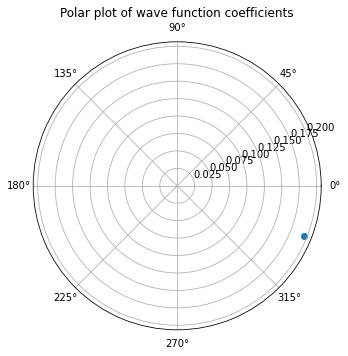

In [8]:
# Evaluate the NQS
coeff = psi(s)

plot_coeffs(coeff)

Let's check how many parameters we have in our NQS ansatz:

In [9]:
psi.get_parameters().shape

(772,)

### Batched evaluation

The NQS class supports batched network evaluations on multiple input configurations, which is crutial for performance.

In [10]:
# Get a batch of random configurations
s_batch = 1*jax.random.bernoulli(jax.random.PRNGKey(1234), shape=(1,13,L))

print(s_batch)

[[[0 1 0 1 0 1 0 1]
  [0 0 1 0 1 1 0 1]
  [1 1 0 1 1 0 1 1]
  [1 1 1 0 1 1 0 0]
  [0 1 1 1 0 1 0 0]
  [1 0 1 1 0 0 1 0]
  [1 1 0 1 1 1 1 0]
  [0 0 1 1 1 0 0 1]
  [1 1 1 0 1 0 0 0]
  [1 0 0 0 1 1 0 1]
  [1 0 0 0 0 1 0 0]
  [1 0 1 1 0 1 0 0]
  [1 1 0 0 0 1 0 1]]]


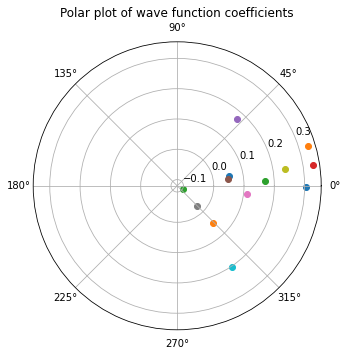

In [11]:
# Evaluate the NQS
coeffs = psi(s_batch)

plot_coeffs(coeffs)

## Operators: Set up observables

The [BranchFreeOperator class](https://jvmc.readthedocs.io/en/latest/operator.html#branch-free-operator-class) can be used to create physical operators.

In [12]:
from jVMC.operator import BranchFreeOperator
from jVMC.operator import Sz, Sx
from jVMC.operator import scal_opstr

Let's create an operator that measures the polarization in the $x$-direction normalized by system size:

$$\hat X=\frac{1}{L}\sum_{l=1}^L\hat\sigma_l^x$$

In [13]:
X = BranchFreeOperator()
for l in range(L):
    X.add( scal_opstr(1. / L, (Sx(l), )) )

The `BranchFreeOperator` class implements the computation of non-zero matrix elements of the operator for a given input configuration:

In [14]:
# Create input configuration (all spins down)
s1 = jax.numpy.zeros((1,1,L), dtype=np.int32)

# Compute non-zero matrix elements
s_primes, matrix_elements = X.get_s_primes(s1)

print("Input configuration:", s1)
print()
print("s_primes:\n", s_primes)
print()
print("matrix_elements:\n", matrix_elements)

Input configuration: [[[0 0 0 0 0 0 0 0]]]

s_primes:
 [[[1 0 0 0 0 0 0 0]
  [0 1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0 0]
  [0 0 0 0 0 1 0 0]
  [0 0 0 0 0 0 1 0]
  [0 0 0 0 0 0 0 1]]]

matrix_elements:
 [[[0.125+0.j 0.125+0.j 0.125+0.j 0.125+0.j 0.125+0.j 0.125+0.j 0.125+0.j
   0.125+0.j]]]


Below we will use this dictionary of observables for measurements.

In [15]:
observables = {
    "X": X
}

## Measuring expectation values: sampling

The [MCSampler class](https://jvmc.readthedocs.io/en/latest/sampler.html#jVMC.sampler.MCSampler) implements Monte Carlo sampling from the given NQS.

In [16]:
from jVMC.sampler import MCSampler

mc_sampler = MCSampler(psi, (L,), 1234, updateProposer=jVMC.sampler.propose_spin_flip)

Generate `numSamples` samples.

In [17]:
configs, coeffs, _ = mc_sampler.sample(numSamples=10)

print("Sampled configurations:\n", configs)
print()
print("Corresponding (log.) wave function coefficients:\n", coeffs)

Sampled configurations:
 [[[0 0 0 0 1 1 0 1]
  [0 1 1 1 1 0 0 0]
  [1 1 0 0 1 0 0 0]
  [1 1 1 0 1 1 0 1]
  [1 0 1 0 0 1 0 0]
  [1 0 1 0 1 1 0 0]
  [1 1 1 0 0 1 1 1]
  [0 0 0 0 1 1 1 1]
  [1 0 0 1 0 0 0 0]
  [1 1 0 1 0 0 0 0]]]

Corresponding (log.) wave function coefficients:
 [[ 0.05239174-9.24646433e-01j  0.1892381 +2.75896435e-01j
   0.45591612-7.11979215e-04j  0.5114704 -2.41984273e-01j
   0.75208627+1.73428944e-01j  0.73408394-4.95823282e-01j
   0.00251713+7.72198383e-02j -0.37526863-1.14500893e+00j
   0.39966146+2.04351030e-03j  0.41050793+5.75771000e-01j]]


Using the `MCSampler` we can now estimate the quantum expectation value

$$\langle\psi_\theta|\hat X|\psi_\theta\rangle=\sum_s\frac{|\psi_\theta(s)|^2}{\langle\psi_\theta|\psi_\theta\rangle}\sum_{s'}X_{s,s'}\frac{\psi_\theta(s')}{\psi_\theta(s)}$$

This is implemented in the utility function [measure](https://jvmc.readthedocs.io/en/latest/util.html#jVMC.util.util.measure).

In [18]:
from jVMC.util import measure

# measure expectation value of observables contained in the dictionary from above
# using the given NQS and sampler.
obs = measure(observables, psi, mc_sampler)

print("Expectation value of X: %.3f+/-%.3f" % (obs["X"]["mean"], obs["X"]["MC_error"]))
print("Variance of X: %.3f" % (obs["X"]["variance"]))

Expectation value of X: 0.903+/-0.014
Variance of X: 0.020


## Computing gradients

The `NQS` class provides a member function to compute the gradient of the (logarithmic) wave function,

$$O_k(s)=\frac{\partial}{\partial\theta_k}\log\psi_\theta(s)$$

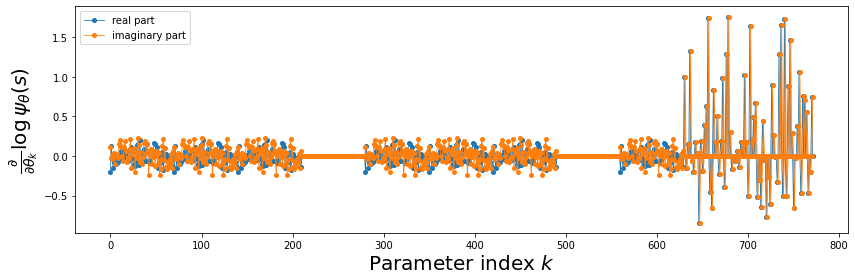

In [19]:
grads = psi.gradients(s)

plot_gradient(grads)

## Create a Hamiltonian

In the following we will be interested in the one-dimensional quantum Ising model:

$$\hat H=-\sum_{l=1}^L\hat\sigma_l^x\hat\sigma_{l+1}^x - g\sum_{l=1}^L\hat\sigma_l^z  - h\sum_{l=1}^L\hat\sigma_l^x $$

In [20]:
g = 0.3
h = 0.25

H = BranchFreeOperator()

for l in range(L):
    H.add( scal_opstr(-1.0, (Sx(l), Sx((l+1)%L))) )    # - Sz(l) Sz(l+1)
    H.add( scal_opstr(-h, (Sx(l),)) )                  # -h Sx(l)
    H.add( scal_opstr(-g, (Sz(l),)) )                  # -g Sz(l)

In [21]:
observables["energy"] = H

## Set up the time-dependent variational principle (TDVP)

The [TDVP class](https://jvmc.readthedocs.io/en/latest/util/tdvp.html#jVMC.util.tdvp.TDVP) from the utilities implements the TDVP time step. It will be used to determine the parameter update $\dot\theta$ using the TDVP equation

$$S_{k,k'}\dot\theta_{k'}=-iF_k$$.

In [22]:
from jVMC.util import TDVP

# Use exact sampler for demonstration purposes
from jVMC.sampler import ExactSampler
sampler = ExactSampler(psi, L)

tdvpEquation = TDVP(sampler, 
                    svdTol=1e-8,
                    rhsPrefactor=1.j,
                    makeReal='imag'
                   )

## Initial ground state search

The dynamics of the quantum Ising model in the ferromagnetic phase with non-vanishing longitudinal field exhibits signatures of confinement when initialized in a longitudinally polarized state, see [Kormos et al., Nat. Phys (2017)](https://www.nature.com/articles/nphys3934).

Therefore, we want to initialize the system in the state

$$|\psi_0\rangle=\bigotimes_l|\rightarrow\rangle_l$$

This is achieved by a ground state search with the Hamiltonian $\hat H_{GS}=-\sum_l\hat\sigma_l^x$.

(Notice that in the Hamiltonian above we defined the $x$-direction as the Ising axis.)

In [23]:
initialize_in_X_state(psi)

## Compute time evolution

Now we are ready to run the simulation.

In [24]:
import time

from IPython.display import clear_output

t = 0.0    # Initial time
dt = 1e-3  # Initial time step
tmax = 4.0 # Total time

# Initialize an adaptive ODE integrator
stepper = jVMC.util.stepper.AdaptiveHeun(timeStep=dt, tol=1e-4)

# Measure observables
obs = measure(observables, psi, sampler)
data = {"parameters": [], "observables": []}
data["observables"].append([t, obs["energy"]["mean"][0], obs["X"]["mean"][0]])
data["parameters"].append(psi.params.unfreeze())

save_to_disk(data, fn="ffn_width="+str(width)+"_")

while t < tmax:
    tic = time.perf_counter()

    # TDVP step
    dp, dt = stepper.step(t,                      # current time
                          tdvpEquation,           # TDVP object
                          psi.get_parameters(),   # current network parameters
                          hamiltonian=H,          # Hamiltonian operator
                          psi=psi,                # NQS object
                          normFunction=partial(norm_fun, df=tdvpEquation.S_dot)
                                                  # Norm for adaptive time step
                         )
    psi.set_parameters(dp)
    t += dt
    
    # Measure observables
    obs = measure(observables, psi, sampler)
    data["observables"].append([t, obs["energy"]["mean"][0], obs["X"]["mean"][0]])
    data["parameters"].append(psi.params.unfreeze())
    
    # Write some meta info to screen
    clear_output(wait=False)
    print(">> t = %f\n" % (t))
    print("   Time step size: dt = %.2e" % (dt))
    tdvpErr, tdvpRes = tdvpEquation.get_residuals()
    print("   Residuals :               TDVP error = %.2e" % (tdvpErr))
    print("               Linear equation residual = %.2e" % (tdvpRes))
    print("      Energy : %f +/- %f" % (obs["energy"]["mean"], obs["energy"]["MC_error"]))
    toc = time.perf_counter()
    print("== Total time for this step: %fs\n" % (toc - tic))
    
save_to_disk(data, fn="ffn_width="+str(width)+"_")

>> t = 4.021447

   Time step size: dt = 3.38e-02
   Residuals :               TDVP error = 1.62e-13
               Linear equation residual = 6.24e-14
      Energy : -10.006212 +/- 0.000000
== Total time for this step: 4.161642s



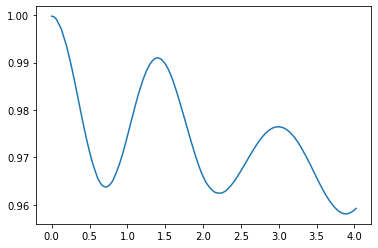

In [25]:
plot_observables(fn="ffn_width="+str(width)+"_")

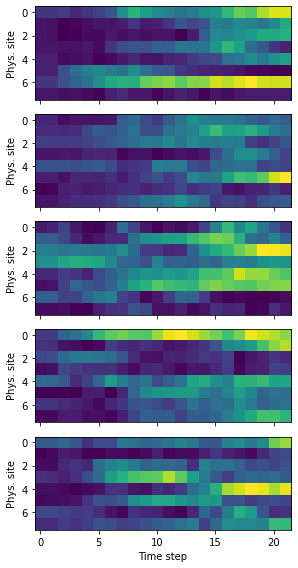

In [26]:
plot_parameters(fn="ffn_width="+str(width)+"_")

In [27]:
!ls

LICENSE                           figures
README.md                         nqs_time_evolution.ipynb
ffn_width=70_L=8_g=0.3_h=0.25.pkl
